In [1]:
import pandas as pd

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
def read_test_data():
    Dfs = []
    train_df = []
    coords = pd.read_csv("data_phase_one/coords.csv", header=None)
    for name in ["mslp", "sst", "ssta", "t2m"]:
        df = pd.read_csv(f"./data_phase_one/test_input_{name}_phase_one.csv", header=None)
        print("Shape df", df.shape)
        Dfs.append(df)
        #Dfs.append(df.T.reset_index(drop=True))
    j = 0
    for i in range(0, df.shape[0], 12):
        feat = pd.concat([coords, Dfs[0].iloc[i:i+12], Dfs[1].iloc[i:i+12], Dfs[2].iloc[i:i+12], Dfs[3].iloc[i:i+12]], axis=0).reset_index(drop=True)
        feat = feat.T.reset_index(drop=True)
        feat.columns = [f"feat_{k}" for k in range(feat.shape[1])]
        if j < 3:
            print(feat.columns)
        train_df.append(feat)
        j += 1
    train_df = pd.concat(train_df, axis=0)
    return train_df

In [4]:
test_data = read_test_data()

Shape df (852, 5774)
Shape df (852, 5774)
Shape df (852, 5774)
Shape df (852, 5774)
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49'],
      dtype='object')
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24

In [5]:
test_data.iloc[0]

feat_0       -64.000000
feat_1      -180.000000
feat_2     99176.120000
feat_3     98542.055000
feat_4     98359.820000
feat_5     97829.700000
feat_6     99006.510000
feat_7     97562.234000
feat_8     97707.880000
feat_9     98543.330000
feat_10    99169.880000
feat_11    99348.850000
feat_12    99290.570000
feat_13    98475.400000
feat_14      275.143520
feat_15      274.579800
feat_16      274.154660
feat_17      273.443020
feat_18      273.121250
feat_19      273.019170
feat_20      272.024100
feat_21      271.832280
feat_22      272.920750
feat_23      274.846500
feat_24      276.528440
feat_25      276.241940
feat_26        0.067444
feat_27        0.104553
feat_28        0.400635
feat_29        0.594055
feat_30        0.967865
feat_31        1.129730
feat_32        0.217712
feat_33       -0.106354
feat_34        0.565674
feat_35        1.453430
feat_36        1.628693
feat_37        0.743347
feat_38      275.346500
feat_39      273.610320
feat_40      270.154240
feat_41      270

In [6]:
test_data.shape

(409954, 50)

In [7]:
monthly_stats = np.load("monthly_stats.npy")

In [8]:
monthly_stats = np.tile(monthly_stats,(len(test_data)//5774,1))

In [9]:
monthly_stats_df = pd.DataFrame(monthly_stats, columns=[f"add_feat_{i}" for i in range(24)])

In [10]:
data_rich = pd.concat([test_data.reset_index(drop=True), monthly_stats_df], axis=1)

In [11]:
import joblib

In [12]:
#lgb_model = joblib.load("./trained_models/lgb_model.joblib")
#catb_model = joblib.load("./trained_models/catb_model.joblib")

In [13]:
#y_pred1 = lgb_model.predict(test_data.values)
#y_pred2 = catb_model.predict(test_data.values)

In [14]:
#y_pred = 0.2*y_pred1 + 0.8*y_pred2 ==> -0.06
#y_pred = 0.55*y_pred1 + 0.45*y_pred2 ==> -0.03
#y_pred = 0.8*y_pred1 + 0.2*y_pred2 ==> -0.01
#y_pred = 0.95*y_pred1 + 0.05*y_pred2 ==> -0.0012
#y_pred = 0.99*y_pred1 - 0.01*y_pred2 ==> 0.0032

In [15]:
#y_pred = 0.99*y_pred1 - 0.01*y_pred2

In [16]:
#pred_df = pd.DataFrame(y_pred.reshape(71, 5774))

In [17]:
#pred_df

In [18]:
#pred_df.to_csv("./predictions.csv", index=False, header=False)

## K-Fold Predictions

In [19]:
import os
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler

In [20]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, coeffs):
        super().__init__()
        self.estimators = estimators
        self.coeffs = coeffs
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [coeff*estimator.predict(X) for estimator, coeff in zip(self.estimators, self.coeffs)]
        return np.sum(y_preds, axis=0)

In [21]:
def load_boosting_models(path, num_folds=5):
    Models = []
    for fold in range(num_folds):
        for model_name in ["catb", "lgb"]:
            for trained_model_path in os.listdir(path):
                if trained_model_path.startswith("."): continue
                if model_name in trained_model_path and f'fold{fold}' in trained_model_path:
                    model = joblib.load(f'{path}/{trained_model_path}')
                    Models.append(model)
    return Models

In [22]:
def load_xgb_models(path, num_folds=5):
    Models = []
    for fold in range(num_folds):
        for model_name in ["xgb"]:
            for trained_model_path in os.listdir(path):
                if trained_model_path.startswith("."): continue
                if model_name in trained_model_path and f'fold{fold}' in trained_model_path:
                    model = joblib.load(f'{path}/{trained_model_path}')
                    Models.append(model)
    return Models

In [23]:
boosting_models = load_boosting_models("./kfold_trained2/", 5)
coeffs = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
boosting_models = VotingModel(boosting_models, coeffs)

In [24]:
add_feat_boosting_models = VotingModel(load_boosting_models("./trained3/"), coeffs)

In [25]:
#scaler = joblib.load("./kfold_trained_preproc/Scaler.joblib")

In [26]:
from pytorch_implementation.dataset import Dataset
from pytorch_implementation.helper_funcs import *

In [27]:
trained_nn_models = load_trained("./trained_nn2")

In [28]:
#len(trained_nn_models)

In [29]:
#y_pred_xgb = xgb_models.predict(test_data.values)

In [30]:
y_pred_boost = boosting_models.predict(test_data.values)
y_pred_add_feat = add_feat_boosting_models.predict(data_rich.values)

In [31]:
y_pred_gru = average_prediction(data_rich.values, trained_nn_models[0::2])
y_pred_lstm = average_prediction(data_rich.values, trained_nn_models[1::2])

In [32]:
y_pred_add_feat

array([0.41890305, 0.60527185, 0.47927709, ..., 0.1407996 , 0.12893621,
       0.67350551])

In [33]:
y_pred_lstm

array([[0.27187973],
       [0.38368812],
       [0.3253692 ],
       ...,
       [0.2611992 ],
       [0.23153245],
       [0.09313384]], dtype=float32)

In [34]:
y_pred_gru

array([[ 0.04392305],
       [ 0.24128263],
       [ 0.15285024],
       ...,
       [-0.15570024],
       [-0.19454904],
       [-0.38507926]], dtype=float32)

In [35]:
y_pred_boost

array([0.41524715, 0.60974182, 0.50326399, ..., 0.16638249, 0.1230431 ,
       0.5932267 ])

In [36]:
#y_pred = 0.15*y_pred_preproc + 0.85*(0.9*y_pred_boost + 0.03*y_pred_gru.squeeze() + 0.07*y_pred_lstm.squeeze())
y_pred = 0.28*y_pred_add_feat + 0.92*(0.92*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.10*y_pred_lstm.squeeze())

In [37]:
pred_df = pd.DataFrame(y_pred.reshape(71, 5774))

In [38]:
pred_df

,0,1,2,3,4,5,6,7,8,9,...,5764,5765,5766,5767,5768,5769,5770,5771,5772,5773
0,0.494175,0.723081,0.591500,0.324180,0.251516,0.245146,0.213620,0.249893,0.215699,0.210263,...,0.023452,-0.007247,0.183551,0.144613,0.062039,0.130447,0.335135,0.150713,0.634102,0.896411
1,-0.531229,-0.574495,-0.544778,-0.529042,-0.692847,-0.591252,-0.475624,-0.407696,-0.366214,-0.448256,...,-0.233259,-0.233780,0.085015,0.204298,0.300743,0.348281,0.404996,0.434149,0.575260,0.973594
2,-0.106790,-0.048000,-0.013175,-0.070861,-0.072452,-0.075449,-0.064034,-0.048561,-0.050297,-0.054792,...,0.057326,0.062514,0.291002,0.363521,0.411017,0.398797,0.504719,0.418365,0.517167,0.480613
3,-0.144159,-0.211016,-0.115584,-0.149748,-0.118057,-0.048591,-0.028547,-0.033440,-0.032104,-0.036120,...,-0.386764,-0.293309,-0.192224,-0.128034,-0.053979,0.034273,-0.080855,-0.119894,0.006737,-0.083188
4,-0.634331,-0.377632,-0.382042,-0.520526,-0.508842,-0.393981,-0.300933,-0.280661,-0.442917,-0.466612,...,-0.533426,-0.578418,-0.332568,-0.153849,-0.010263,0.067957,-0.023659,0.142540,0.397401,0.051792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.660441,0.509131,0.442081,0.282734,0.119101,0.078653,0.100688,0.181850,0.145658,0.149389,...,-0.194821,-0.235358,0.115708,0.266027,0.320098,0.438959,0.465017,0.391297,0.639155,0.342230
67,0.196535,0.238813,0.266951,0.145800,0.109243,0.073954,0.089622,0.085892,0.083803,0.049855,...,-0.167736,-0.066393,0.192572,0.337548,0.382741,0.418326,0.545432,0.323371,0.521361,0.411078
68,-0.307988,-0.278596,-0.284869,-0.304371,-0.268092,-0.332365,-0.262018,-0.199252,-0.231574,-0.200769,...,0.527567,0.529489,0.666388,0.693600,0.582641,0.551058,0.858101,0.713681,0.813521,0.542848
69,0.058535,-0.014392,0.082270,0.065528,0.061914,0.050955,0.057311,0.054639,0.033105,-0.002359,...,-0.124584,-0.043687,0.387605,0.426481,0.443327,0.365750,0.419546,0.172853,0.304330,-0.081044


In [39]:
pred_df.to_csv("./predictions_phase_one.csv", index=False, header=False)

In [40]:
target = pd.read_csv("target/data_test_output/test_output_phase_two.csv", header=None)

In [41]:
target

,0,1,2,3,4,5,6,7,8,9,...,5764,5765,5766,5767,5768,5769,5770,5771,5772,5773
0,0.411591,0.157654,0.089264,-0.073944,-0.019226,-0.031738,-0.004822,0.038910,-0.019714,-0.101685,...,0.392609,0.168915,0.570709,0.597748,0.655182,0.762756,0.701508,0.310120,0.853088,0.745392
1,0.601501,0.649902,0.670837,0.767914,0.668884,0.300964,0.097168,0.245819,0.298950,0.226532,...,0.468079,0.520935,0.657745,0.342499,0.155609,0.258484,0.816315,0.801208,1.828857,4.267487
2,-0.649170,-0.531006,-0.351196,-0.485901,-0.470581,-0.647430,-0.420715,-0.299103,-0.310059,-0.350311,...,0.291565,0.244598,0.477020,0.241272,0.143097,0.267090,-0.059967,0.206848,0.110291,0.404633
3,-0.291077,-0.292206,-0.247131,-0.161468,-0.111694,-0.043610,-0.023865,-0.013428,-0.009125,-0.009796,...,-0.348907,-0.287323,-0.204254,0.090363,0.299225,0.359802,0.341278,0.167450,0.164032,0.494781
4,-0.600769,-0.592987,-0.509125,-0.447723,-0.391144,-0.290405,-0.225128,-0.199341,-0.189880,-0.166657,...,0.117249,0.126831,0.372681,0.431305,0.371765,0.497284,0.329620,0.054565,0.705811,1.399475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,1.568756,1.389984,1.385651,1.256775,0.890259,0.372406,0.238464,0.220154,0.179291,0.134735,...,0.946747,0.784760,1.124817,0.758698,0.431213,0.460663,0.553925,0.225708,0.658020,1.142975
67,0.315643,0.499237,0.449036,0.386292,0.061859,-0.048584,-0.049133,-0.033112,-0.038879,-0.045929,...,0.130096,0.203522,0.436340,0.290924,0.131989,0.148163,0.529144,0.681244,1.655701,0.043060
68,-0.075043,-0.070312,0.004333,-0.146179,-0.123199,-0.009979,0.082214,0.116974,0.155670,0.150085,...,-0.118500,-0.175781,0.156921,0.239288,0.349304,0.569427,0.436615,0.436829,1.062714,1.606049
69,-0.852142,-0.236755,-0.247253,-0.549377,-0.512482,-0.415283,-0.237915,-0.366211,-0.457642,-0.516754,...,0.276337,0.236908,0.445374,0.317566,0.347809,0.445404,0.105347,0.323700,-0.266022,-0.018524


In [42]:
import matplotlib.pyplot as plt

In [43]:
cols = [0, 1003, 273]

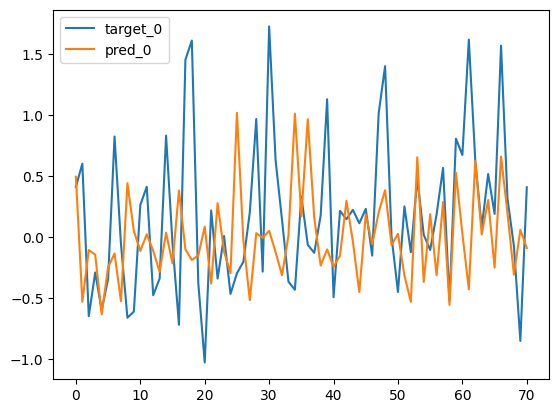

In [44]:
plt.plot(target[cols[0]])
plt.plot(pred_df[cols[0]])

plt.legend([f"target_{cols[0]}", f"pred_{cols[0]}"])
plt.show()

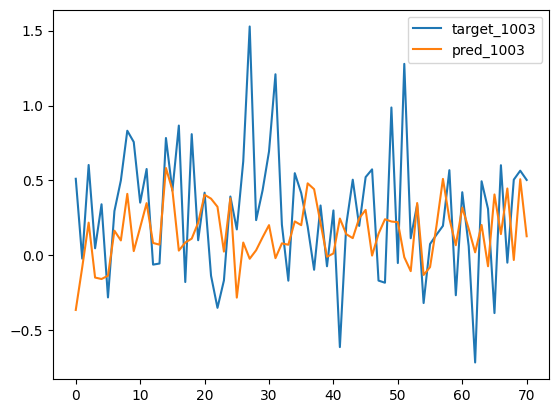

In [45]:
plt.plot(target[cols[1]])
plt.plot(pred_df[cols[1]])

plt.legend([f"target_{cols[1]}", f"pred_{cols[1]}"])
plt.show()

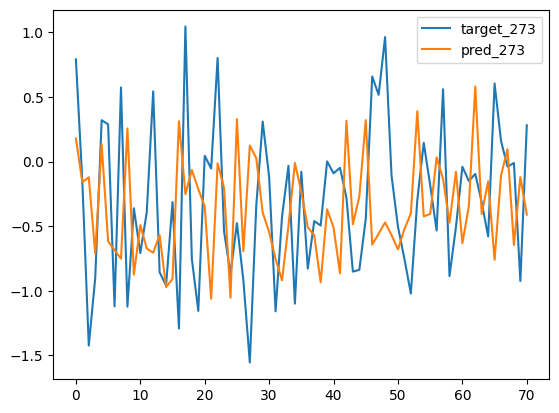

In [46]:
plt.plot(target[cols[2]])
plt.plot(pred_df[cols[2]])

plt.legend([f"target_{cols[2]}", f"pred_{cols[2]}"])
plt.show()

In [47]:
from starting_kit_phase_one.evaluation import evaluate

In [48]:
print("Phase One...")
test_y_file = './target/data_test_output/test_output_phase_one.csv'
baseline_file = './starting_kit_phase_one/out/test_output_pred_persist_phase_one.csv'
prediction_file = './predictions_phase_one.csv'
evaluate(test_y_file, baseline_file, prediction_file)
print("\n\n")
print("Phase Two")
test_y_file = './target/data_test_output/test_output_phase_two.csv'
baseline_file = './test_output_pred_persist_phase_two.csv'
prediction_file = './predictions_phase_two.csv'
evaluate(test_y_file, baseline_file, prediction_file)

Phase One...
Average RMSE (Baseline): 0.649344200427837
Average RMSE (Model): 0.5502102328489467
Final Result (Baseline RMSE - Model RMSE): 0.09913396757889037



Phase Two
Average RMSE (Baseline): 0.6561923737328125
Average RMSE (Model): 0.5689849078876463
Final Result (Baseline RMSE - Model RMSE): 0.08720746584516614


0.08720746584516614

In [49]:
# KFold

# catb 500 estimators, lgbm 1000 estimators
# [0.05, 0.15, 0.05, 0.15, 0.05, 0.15, 0.05, 0.15, 0.05, 0.15] ==> 0.093

# catb and lgb 1000 estimators
# [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] ==> 0.094

# catb and lgb 1000 estimators
# ([0.08, 0.12, 0.08, 0.12, 0.1, 0.1, 0.1, 0.1, 0.06, 0.14])*0.91 + 0.01*gru + 0.09*lstm ==> 0.0951
# y_pred = 0.25*y_pred_add_feat + 0.90*(0.91*y_pred_boost + 0.02*y_pred_gru.squeeze() + 0.10*y_pred_lstm.squeeze()) ==> 0.0985
# y_pred = 0.28*y_pred_add_feat + 0.95*(0.92*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.09*y_pred_lstm.squeeze()) ==> 0.09862
# linear comb catb lgb and newly trained gru + lstm: y_pred = 0.28*y_pred_add_feat + 0.95*(0.92*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.09*y_pred_lstm.squeeze()) ==> 0.0989
# linear catb and lgb + newly trained lstm and gru: y_pred = 0.28*y_pred_add_feat + 0.94*(0.92*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.10*y_pred_lstm.squeeze()) ==> 0.0991
# even better: y_pred = 0.28*y_pred_add_feat + 0.92*(0.92*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.10*y_pred_lstm.squeeze()) ==> 0.09913
# y_pred = 0.91*y_pred_boost + 0.01*y_pred_gru.squeeze() + 0.09*y_pred_lstm.squeeze()